In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
proc = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

In [2]:
fulldata = pd.read_csv('/kaggle/input/cic-iot-final/fulldata.csv')

In [3]:
fulldata['Label'].value_counts()

Label
DDoS-ICMP_Flood            2798619
DDoS-UDP_Flood             2102365
DDoS-TCP_Flood             1750111
DDoS-PSHACK_Flood          1595240
DDoS-SYN_Flood             1580274
DDoS-RSTFINFlood           1573279
DDoS-SynonymousIP_Flood    1398082
DoS-UDP_Flood              1290211
DoS-TCP_Flood              1037432
DoS-SYN_Flood               788929
Benign                      427477
Mirai-greeth_flood          385569
Mirai-udpplain              346290
Mirai-greip_flood           291978
DDoS-ICMP_Fragmentation     176572
Name: count, dtype: int64

In [4]:
def change_label(df):
    # Replace labels with new categories
    df.loc[df.Label.isin(['DDoS-ICMP_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood','DDoS-PSHACK_Flood','DDoS-SYN_Flood','DDoS-RSTFINFlood','DDoS-SynonymousIP_Flood','DDoS-ICMP_Fragmentation','DDoS-UDP_Fragmentation','DDoS-ACK_Fragmentation','DDoS-HTTP_Flood','DDoS-SlowLoris']), 'Label'] = 'DDoS'
    df.loc[df.Label.isin(['DoS-UDP_Flood','DoS-TCP_Flood','DoS-SYN_Flood','DoS-HTTP_Flood']), 'Label'] = 'DoS'
    df.loc[df.Label.isin(['Recon-HostDiscovery','Recon-OSScan','Recon-PortScan','Recon-PingSweep','VulnerabilityScan']), 'Label'] = 'Recon'
    df.loc[df.Label.isin(['MITM-ArpSpoofing','DNS_Spoofing']), 'Label'] = 'Spoofing'
    df.loc[df.Label.isin(['DictionaryBruteForce']), 'Label'] = 'BruteForce'
    df.loc[df.Label.isin(['BrowserHijacking','XSS','Uploading_Attack','SqlInjection','CommandInjection','Backdoor_Malware']), 'Label'] = 'Web-based'
    df.loc[df.Label.isin(['Mirai-greeth_flood','Mirai-udpplain','Mirai-greip_flood']), 'Label'] = 'Mirai'
    df.loc[df.Label.isin(['BenignTraffic']), 'Label'] = 'BENIGN'
    # Shuffle the DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

# Apply the function to your DataFrame
change_label(fulldata)

# Display the value counts of the labels after shuffling
print(fulldata['Label'].value_counts())

Label
DDoS      12974542
DoS        3116572
Mirai      1023837
Benign      427477
Name: count, dtype: int64


In [5]:
train_datas = {}
old=[]
mixed_data = pd.DataFrame()
test_data = pd.DataFrame()
for i in fulldata['Label'].unique():
    if fulldata[fulldata['Label'] == i].shape[0] > 100000 and i!="Benign": 
        print(i)
        old.append(i)
        train_datas[i] = fulldata[fulldata['Label'] == i][:400000]
        mixed_data = pd.concat([mixed_data, fulldata[fulldata['Label'] == i][400000:405000]], axis=0)
        test_data = pd.concat([test_data, fulldata[fulldata['Label'] == i][405000:410000]], axis=0)

DoS
DDoS
Mirai


In [6]:
new=["DDoS-1","DDoS-2","DoS-1","DoS-2","DoS-3","Mirai-1","Mirai-2"]
train_datas["DDoS-1"]=fulldata[fulldata['Label'] == "DDoS"][410000:440000]
train_datas["DDoS-2"]=fulldata[fulldata['Label'] == "DDoS"][440000:540000]
train_datas["DoS-1"]=fulldata[fulldata['Label'] == "DoS"][410000:510000]
train_datas["DoS-2"]=fulldata[fulldata['Label'] == "DoS"][510000:530000]
train_datas["DoS-3"]=fulldata[fulldata['Label'] == "DoS"][530000:531000]
train_datas["Mirai-1"]=fulldata[fulldata['Label'] == "Mirai"][410000:480000]
train_datas["Mirai-2"]=fulldata[fulldata['Label'] == "Mirai"][480000:485000]

In [7]:
train_datas.keys()

dict_keys(['DoS', 'DDoS', 'Mirai', 'DDoS-1', 'DDoS-2', 'DoS-1', 'DoS-2', 'DoS-3', 'Mirai-1', 'Mirai-2'])

In [ ]:
del fulldata

In [8]:
mixed_data = mixed_data.sample(frac=1).reset_index(drop=True)
mixed_data_labels = list(mixed_data['Label'])
mixed_data.drop(['Label'], axis=1, inplace=True)
mixed_data = mixed_data.to_numpy()

test_data = test_data.sample(frac=1).reset_index(drop=True)
test_data_labels = list(test_data['Label'])
test_data.drop(['Label'], axis=1, inplace=True)
test_data = test_data.to_numpy()


for i in train_datas:
    train_datas[i].drop(['Label'], axis=1, inplace=True)
    train_datas[i] = train_datas[i].sample(frac=1).reset_index(drop=True)
    train_datas[i] = train_datas[i].to_numpy()

In [9]:
train_loader = {}
batch_size=16
devices = []
for i in train_datas:
    train_loader[i] = DataLoader(train_datas[i], batch_size=batch_size, shuffle=True)
    devices.append(i)

In [9]:
train_loader.keys()

dict_keys(['DoS', 'DDoS', 'Mirai', 'DDoS-1', 'DDoS-2', 'DoS-1', 'DoS-2', 'DoS-3', 'Mirai-1', 'Mirai-2'])

In [10]:
for label in train_datas.keys():
    print(len(train_datas[label]),train_datas[label].shape)

400000 (400000, 46)
400000 (400000, 46)
400000 (400000, 46)
30000 (30000, 46)
100000 (100000, 46)
100000 (100000, 46)
20000 (20000, 46)
1000 (1000, 46)
70000 (70000, 46)
5000 (5000, 46)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['DoS'].dataset.shape[1]

# Define AEModel with regularization
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 18)
        self.fc5 = nn.Linear(18, 12)
        self.fc6 = nn.Linear(12, 12)
        self.fc7 = nn.Linear(12, 18)
        self.fc8 = nn.Linear(18, 24)
        self.fc9 = nn.Linear(24, 32)
        self.fc10 = nn.Linear(32, input_dim)
        self.fc11 = nn.Linear(input_dim, input_dim) 
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc7(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc8(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc9(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc10(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc11(x)
        return x

In [12]:
# Function for client update with regularization
def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    criterion = nn.MSELoss(reduction='mean')
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
            output = client_model(data.float())
            optimizer.zero_grad()
            loss = criterion(data.float().to(proc), output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_data)
    return epoch_loss

In [ ]:
client_models = {i: AEModel(input_dim).to(proc) for i in devices}
opt = {i: optim.SGD(client_models[i].parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5) for i in devices}

In [ ]:
opt = {i: optim.SGD(client_models[i].parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-5) for i in devices}

In [ ]:

num_clients = len(train_loader)      
num_selected = len(train_loader)    

num_rounds = 1 
epochs = 32

In [ ]:
# Train Client Model and Global Model
start_time = time.time()
for r in range(num_rounds):  # total number of rounds
    print('\nround: ', r+1)
    loss = 0
    for i in devices:
        if i=="Benign":
            print(i)
            l = client_update(client_models[i], opt[i], train_loader[i], epochs)
            print('client: ', i, 'loss: ', l)
            loss += l
time_required = time.time() - start_time
print('/nTIME: {}mins'.format(time_required/60))

In [ ]:
import os
try:
    os.makedirs('/kaggle/working/models_ciciot/')
except:
    pass
for i in devices:
    torch.save(client_models[i],'/kaggle/working/models_ciciot/' + i + '.pt')

In [ ]:
client_models = {}
for device in old:
    client_models[device] = torch.load('/kaggle/input/ciciot/keras/working/4/' + device + '.pt')
client_models.keys()

In [ ]:
def quan_thresh(model, dataloader, quantile=0.9):
    model.eval()
    se = []
    for batch in dataloader:
        for data in batch:
            error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
            se.append(sum(error))
    return np.mean(se) + np.std(se), np.quantile(se, quantile), se 

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
            TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
            FP += 1
        if y_actual[i] == y_pred[i] == 0:
            TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
            FN += 1
    return (TP, FP, TN, FN)

In [ ]:
client_models = {}
for device in devices:
    client_models[device] = torch.load('/kaggle/input/ciciot/keras/updated_fed/1/' + device + '.pt')
client_models.keys()

In [ ]:
quans = {}
errors = {}
for device in devices:
    if device not in thresholds.keys():
        model = client_models[device]
        dataloader = train_loader[device]
        thresholds[device], quans[device], errors[device] = quan_thresh(model, dataloader)
print(thresholds)

In [ ]:
# fed
thresholds={'DoS': 0.1706238170265029, 'DDoS': 0.21325140276392854, 'Mirai': 0.17549660693457173, 'DDoS-1': 0.23128215112027156, 'DDoS-2': 0.22874046836270984, 'DoS-1': 0.15856312760757496, 'DoS-2': 0.15543832228696705, 'DoS-3': 0.6030446764939741, 'Mirai-1': 0.28304482188307956, 'Mirai-2': 0.4924809134920508}

In [ ]:
thresholds={'DoS': 0.087032180133148,
 'DDoS': 0.12717986146862245,
 'Mirai': 0.08266005305226577}

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
    model = client_models[device]
    model.eval()
    labels = mixed_data_labels
    threshold = thresholds[device]
    temp=[]
    y_true = []
    y_pred = []
    ind = 0
    for data in mixed_data:
        data = torch.Tensor(data)
        error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
        temp.append(error)
        if device[:-2] == labels[ind]:
            y_true.append(1)
            y_pred.append(1 if error < threshold else 0)
        else:
            y_true.append(0)
            y_pred.append(0 if error >= threshold else 1)
        ind += 1
    res.append([device,min(temp),max(temp)])
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    TP += 1
    FN += 1
    TN += 1
    FP += 1
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with mixed data")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))
    TPR = round((TP / (TP+FN)), 6)
    FPR = round((FP / (FP + TN)), 6)
    selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with mixed data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

In [ ]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['DoS'].dataset.shape[1]

# Define AEModel with regularization
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 18)
        self.fc5 = nn.Linear(18, 12)
        self.fc6 = nn.Linear(12, 12)
        self.fc7 = nn.Linear(12, 18)
        self.fc8 = nn.Linear(18, 24)
        self.fc9 = nn.Linear(24, 32)
        self.fc10 = nn.Linear(32, input_dim)
        self.fc11 = nn.Linear(input_dim, input_dim) 
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc7(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc8(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc9(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc10(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc11(x)
        return x

In [ ]:
# Define the encoder-only model class
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 18)
        self.fc5 = nn.Linear(18, 12)
        self.fc6 = nn.Linear(12, 12)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.2
        
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data

# Update client_models to use the encoder-only model
client_models_encoders = {}
for device in devices:
    full_model = torch.load('/kaggle/input/ciciot/keras/working/4/' + device + '.pt')
    encoder_model = AEModelEncoder(input_dim)
    load_encoder_weights(full_model, encoder_model)
    client_models_encoders[device] = encoder_model
client_models_encoders.keys()

In [ ]:
agg_models={}
client_lens={}
agg_models_labels={}
for i in client_models_encoders.keys():
    if i[:-2] in client_models_encoders.keys():
        try:
            agg_models[i[:-2]].append(client_models_encoders[i])
            agg_models_labels[i[:-2]].append(i)
            client_lens[i[:-2]].append(len(train_datas[i]))
            print(i)
        except:
            print(i)
            agg_models[i[:-2]]=[client_models_encoders[i[:-2]],client_models_encoders[i]]
            agg_models_labels[i[:-2]]=[i[:-2],i]
            client_lens[i[:-2]]=[len(train_datas[i[:-2]]),len(train_datas[i])]

In [ ]:
opt = {i: optim.SGD(client_models[i].parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5) for i in devices}

In [ ]:
def server_aggregate_fedprox(global_model, client_models, mu=0.05):
    n = len(client_models)
    global_dict = global_model.state_dict()
    
    for k in global_dict.keys():
        # Calculate the average of the client model parameters
        global_weight = sum(client_models[i].state_dict()[k].float() for i in range(n)) / n
        
        # Apply the FedProx proximal term
        prox_term = mu * global_dict[k]
        global_dict[k] = (global_weight + prox_term) / (1 + mu)
    
    # Load the updated parameters into the global model
    global_model.load_state_dict(global_dict)
    
    # Update each client model with the new global parameters
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [ ]:
epochs=5
trained=[]
for r in range(5):
    print('\nround: ', r+1)
    for i in agg_models.keys():
        server_aggregate_fedprox(client_models_encoders[i],agg_models[i])
        for k in agg_models[i]:
            for j in client_models_encoders.keys():
                if agg_models_labels[i][agg_models[i].index(k)] == j:
                    load_encoder_weights(client_models_encoders[j],client_models[j])
    for j in client_models.keys():
        if j[:-2] in client_models.keys():
            if j[:-2] not in trained:
                loss = 0
                l = client_update(client_models[j[:-2]], opt[j[:-2]], train_loader[j[:-2]], epochs)
                print('client: ', j[:-2], 'loss: ', l)
                loss += l
                trained.append(j[:-2])
            loss = 0
            l = client_update(client_models[j], opt[j], train_loader[j], epochs)
            print('client: ', j, 'loss: ', l)
            loss += l
    trained=[]
    for i in agg_models.keys():
        for k in agg_models[i]:
            for j in client_models.keys():
                if agg_models_labels[i][agg_models[i].index(k)] == j:
                    load_encoder_weights(client_models[j],k)
        

for i in agg_models.keys():
    server_aggregate_fedprox(client_models_encoders[i],agg_models[i])
    for k in agg_models[i]:
        for j in client_models_encoders.keys():
            if agg_models_labels[i][agg_models[i].index(k)] == j:
                load_encoder_weights(client_models_encoders[j],client_models[j])

In [ ]:
import os
try:
    os.makedirs('/kaggle/working/models_extra/clients/')
except:
    pass
for i in devices:
    torch.save(client_models[i],'/kaggle/working/models_extra/clients/' + i + '.pt')

In [ ]:
for i in devices:
    print(i)

# Global model creation (K-means)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

input_dim = train_loader['DoS'].dataset.shape[1]

# Define AEModel with regularization
class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 18)
        self.fc5 = nn.Linear(18, 12)
        self.fc6 = nn.Linear(12, 12)
        self.fc7 = nn.Linear(12, 18)
        self.fc8 = nn.Linear(18, 24)
        self.fc9 = nn.Linear(24, 32)
        self.fc10 = nn.Linear(32, input_dim)
        self.fc11 = nn.Linear(input_dim, input_dim) 
        self.activation = nn.Tanh()
        #self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.5
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        #x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        #x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc7(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc8(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc9(x)
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc10(x) 
        x = self.activation(x)
        #x = self.dropout(x)
        x = self.fc11(x)
        return x

In [91]:
"""client_models = {}
for device in devices:
    client_models[device] = torch.load('/kaggle/input/ciciot/keras/working/1/' + device + '.pt')"""

"client_models = {}\nfor device in devices:\n    client_models[device] = torch.load('/kaggle/input/ciciot/keras/working/1/' + device + '.pt')"

In [17]:
# Define the encoder-only model class
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 18)
        self.fc5 = nn.Linear(18, 12)
        self.fc6 = nn.Linear(12, 12)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.2
        
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data

# Update client_models to use the encoder-only model
client_models = {}
for device in old:
    full_model = torch.load('/kaggle/input/ciciot/keras/working/4/' + device + '.pt')
    encoder_model = AEModelEncoder(input_dim)
    load_encoder_weights(full_model, encoder_model)
    client_models[device] = encoder_model
client_models.keys()

dict_keys(['DoS', 'DDoS', 'Mirai'])

In [15]:
compressed_outs = {}
compressed_outs_test = {}

for i in client_models:
    model = client_models[i]
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float())
            outs.append(layer_output)
            ind += 1
            if ind == 30000:
                compressed_outs[i] = outs
                outs = []
            elif ind == 30010:
                compressed_outs_test[i] = outs
                flag = True
                break
        if flag:
            break

In [16]:
for i in compressed_outs.keys():
    print(i,': ',len(compressed_outs[i]))


DoS :  30000
DDoS :  30000
Mirai :  30000


In [17]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np

# Extract data from the dictionary
data = []
labels = []

for label, tensors in compressed_outs.items():
    for tensor in tensors:
        data.append(tensor.detach().numpy())
        labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Get the number of samples
num_samples = len(data)

# Generate a random permutation of indices
permutation_indices = np.random.permutation(num_samples)

# Shuffle data and labels arrays using the permutation
shuffled_data = data[permutation_indices]
shuffled_labels = labels[permutation_indices]
data=shuffled_data
labels=shuffled_labels

In [15]:
import joblib
n=13
kmeans = joblib.load('/kaggle/input/ciciot/scikitlearn/kmeans/1/kmeans_models/kmeans_model.joblib')

In [97]:
"""n=13
# Apply KMeans clustering
kmeans = KMeans(n_clusters=n, random_state=100)"""

'n=13\n# Apply KMeans clustering\nkmeans = KMeans(n_clusters=n, random_state=100)'

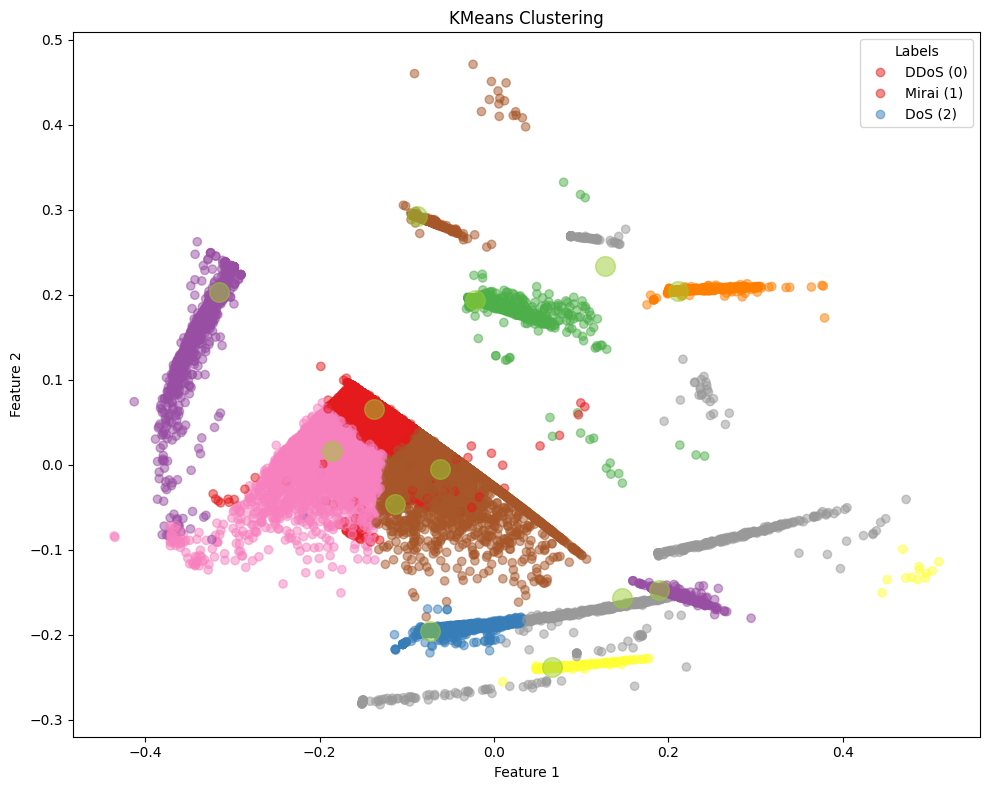

In [19]:
#cluster_labels = kmeans.fit_predict(data)
cluster_labels=kmeans.predict(data)
# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Create a larger figure
fig, ax = plt.subplots(figsize=(10, 8))

# Visualize the clusters with different colors for each label
scatter = ax.scatter(data[:, 0], data[:, 1], c=cluster_labels, cmap='Set1', alpha=0.5)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], c='yellowgreen', s=200, alpha=0.5)

# Add legend with label names only if there are valid elements
if scatter.legend_elements()[0] is not None and len(scatter.legend_elements()[0]) > 0:
    unique_labels = list(set(labels))
    legend_labels = [f'{label} ({i})' for i, label in enumerate(unique_labels)]
    ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Labels')

ax.set_title('KMeans Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.tight_layout()

plt.show()

In [99]:
# Dictionary to store attacks and their counts for each cluster
cluster_attacks_count = {cluster: {} for cluster in range(n)}

# Iterate through data and cluster labels
for idx, cluster_label in enumerate(cluster_labels):
    attack = labels[idx]
    if attack not in cluster_attacks_count[cluster_label]:
        cluster_attacks_count[cluster_label][attack] = 1
        
    else:
        cluster_attacks_count[cluster_label][attack] += 1
    
# Print attacks and their counts for each cluster
for cluster, attack_counts in cluster_attacks_count.items():
    print(f"Cluster {cluster}: {attack_counts}")

Cluster 0: {'Mirai': 95}
Cluster 1: {'Mirai': 14861}
Cluster 2: {'DDoS': 24180}
Cluster 3: {'DoS': 25185}
Cluster 4: {'Mirai': 3959}
Cluster 5: {'DoS': 2598}
Cluster 6: {'DDoS': 3484}
Cluster 7: {'DDoS': 1612}
Cluster 8: {'DoS': 2114}
Cluster 9: {'Mirai': 4804}
Cluster 10: {'Mirai': 6281}
Cluster 11: {'DoS': 103}
Cluster 12: {'DDoS': 724}


In [100]:
cluster_attacks_count

{0: {'Mirai': 95},
 1: {'Mirai': 14861},
 2: {'DDoS': 24180},
 3: {'DoS': 25185},
 4: {'Mirai': 3959},
 5: {'DoS': 2598},
 6: {'DDoS': 3484},
 7: {'DDoS': 1612},
 8: {'DoS': 2114},
 9: {'Mirai': 4804},
 10: {'Mirai': 6281},
 11: {'DoS': 103},
 12: {'DDoS': 724}}

In [101]:
cluster_labels = {}
for i in range(n):
    cluster_labels[i] = max(cluster_attacks_count[i], key=cluster_attacks_count[i].get)
cluster_labels

{0: 'Mirai',
 1: 'Mirai',
 2: 'DDoS',
 3: 'DoS',
 4: 'Mirai',
 5: 'DoS',
 6: 'DDoS',
 7: 'DDoS',
 8: 'DoS',
 9: 'Mirai',
 10: 'Mirai',
 11: 'DoS',
 12: 'DDoS'}

In [16]:
cluster_labels = {0: 'Mirai',
 1: 'Mirai',
 2: 'DDoS',
 3: 'DoS',
 4: 'Mirai',
 5: 'DoS',
 6: 'DDoS',
 7: 'DDoS',
 8: 'DoS',
 9: 'Mirai',
 10: 'Mirai',
 11: 'DoS',
 12: 'DDoS'}

In [ ]:
"""removed=['DDoS-SYN_Flood','DoS-SYN_Flood','DDoS-UDP_Flood','Mirai-udpplain']
mixed_data = mixed_data.tolist()
i=0
for label in  mixed_data_labels:
    if label in removed:
        mixed_data_labels.pop(i)
        mixed_data.pop(i)
mixed_data = np.array(mixed_data)"""

In [ ]:
"""del fulldata
del train_loader"""

In [18]:
compressed_mixed = {}
j=0
for data in mixed_data:
    if j<1000:
        for i in client_models:
            model = client_models[i]
            model.eval()
            layer_output = model(torch.Tensor(data))
            try:
                compressed_mixed[i].append(layer_output)
            except:
                compressed_mixed[i] = [layer_output]
    j+=1


In [19]:
old_thresholds={'DoS': 0.087032180133148,
 'DDoS': 0.12717986146862245,
 'Mirai': 0.08266005305226577}

In [21]:
def classify_new_data(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False

num_encoders=3
num_clusters=13
num_clients=3
met=[]
start = 0
end =  min(old_thresholds.values())*num_encoders
step = end/num_clusters
i = start
first_round=[]
prev_TPR=0

for x in range(num_clients):
    met=[]
    print("Round :"+str(x+1))
    while i < end:
        TP,FP,TN,FN = 0,0,0,0
        # Iterate through the compressed_mixed dictionary and classify each data point
        for model, data_list in compressed_mixed.items():
            j = 0
            for data in data_list:
                # Convert the data to NumPy array and detach from computation graph
                data_np = data.detach().numpy()
                data_np = data_np.reshape(1,-1)
                # Convert the data to double data type before passing it to KMeans model
                if classify_new_data(data_np, i) == False:
                    classification_result = False
                else: 
                    classification_result = cluster_labels[classify_new_data(data_np, i)]
                if classification_result == False:
                    if model == mixed_data_labels[j]:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if classification_result == mixed_data_labels[j]:
                        if model == mixed_data_labels[j]:
                            TP += 1
                        else:
                            FP += 1
                    else:
                        FN += 1
                j += 1

        if TP==0:
            TP=0.1
            
        # Calculate accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        # Calculate true positive rate (TPR) or sensitivity or recall
        TPR = TP / (TP + FN)

        # Calculate false positive rate (FPR)
        FPR = FP / (FP + TN)

        # Calculate specificity or true negative rate (TNR)
        TNR = TN / (FP + TN)

        # Calculate precision or positive predictive value (PPV)
        PPV = TP / (TP + FP)

        met.append([i,accuracy,TPR,FPR,TNR])
        if x==0:
            first_round.append([i,accuracy,TPR,FPR,TNR])
        i += step
    print(met)
    # Extracting data from 'fed_met' list
    thresholds = [entry[0] for entry in met]
    TPR = [entry[2] for entry in met]

    # Find the best thresholds
    # best_accuracy_idx = np.argmax(accuracy)

    best_tpr_idx = np.argmax(TPR)
    best_TPR = round(TPR[best_tpr_idx], 4)
    if best_tpr_idx==0:
        start=thresholds[best_tpr_idx]
    else:
        start=thresholds[best_tpr_idx-1]
    if best_tpr_idx == len(thresholds) - 1:
        end = thresholds[best_tpr_idx]
    else:
        end = thresholds[best_tpr_idx + 1]
    step = end/num_clusters
    i=start
    if prev_TPR==best_TPR:
        break
    prev_TPR=best_TPR
    #nxt_acc_thresh = threshold
    #nxt_acc_thresh = thresholds[best_accuracy_idx+1]
    #nxt_tpr_thresh = thresholds[best_tpr_idx+1]


Round :1
[[0, 0.6666777774074197, 9.999000099990002e-05, 0.0, 1.0], [0.01907539685821518, 0.7583333333333333, 0.275, 0.0, 1.0], [0.03815079371643036, 0.8666666666666667, 0.6, 0.0, 1.0], [0.05722619057464554, 0.8906666666666667, 0.672, 0.0, 1.0], [0.07630158743286072, 0.909, 0.727, 0.0, 1.0], [0.09537698429107591, 0.9233333333333333, 0.77, 0.0, 1.0], [0.1144523811492911, 0.9716666666666667, 0.915, 0.0, 1.0], [0.1335277780075063, 0.9763333333333334, 0.929, 0.0, 1.0], [0.15260317486572147, 0.9826666666666667, 0.948, 0.0, 1.0], [0.17167857172393666, 0.986, 0.958, 0.0, 1.0], [0.19075396858215185, 0.9883333333333333, 0.965, 0.0, 1.0], [0.20982936544036704, 0.978, 0.9362934362934363, 0.0, 1.0], [0.22890476229858223, 0.966, 0.9051162790697674, 0.0, 1.0]]
Round :2
[[0.17167857172393666, 0.986, 0.958, 0.0, 1.0], [0.18781929214242643, 0.987, 0.961, 0.0, 1.0], [0.2039600125609162, 0.9883333333333333, 0.9651394422310757, 0.0, 1.0]]
Round :3
[[0.18781929214242643, 0.987, 0.961, 0.0, 1.0], [0.2035085

In [22]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in met]
accuracy = [entry[1] for entry in met]
TPR = [entry[2] for entry in met]
FPR = [entry[3] for entry in met]
TNR = [entry[4] for entry in met]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]
best_fpr_threshold = thresholds[best_fpr_idx]

best_tpr_threshold

0.20350852387788151


Best Accuracy: 0.98833 at threshold 0.19075396858215185 
Best TPR: 0.96500 at threshold 0.19075396858215185



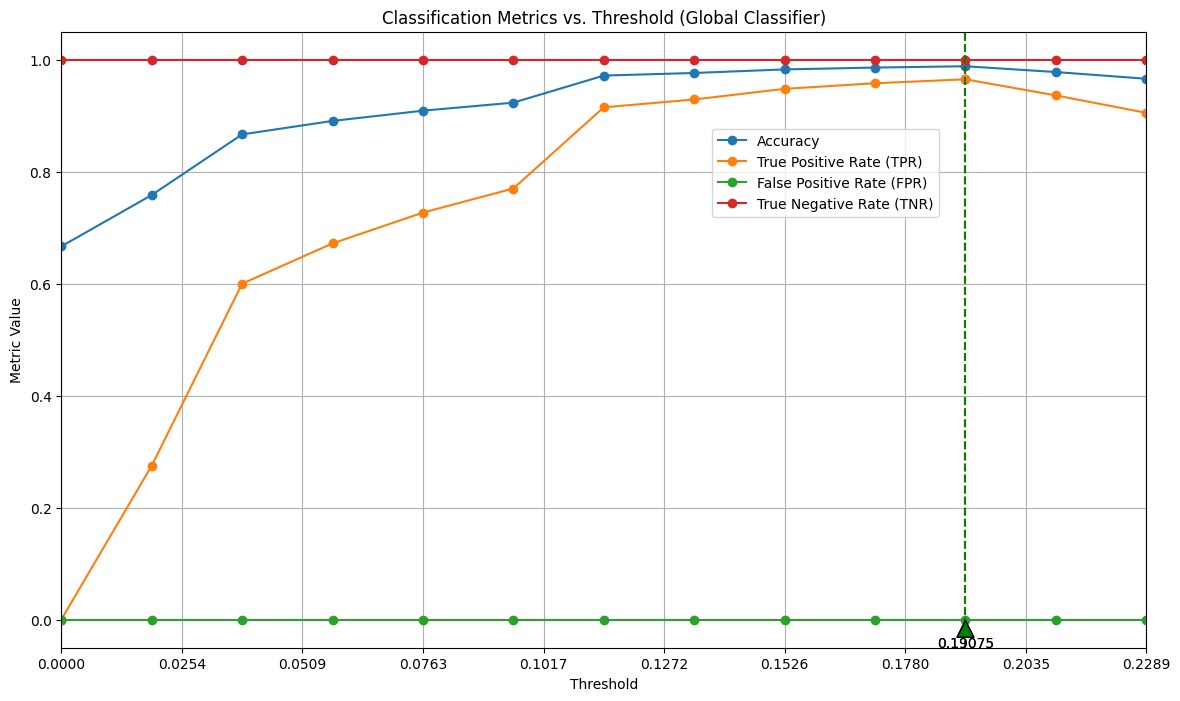

In [23]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in first_round]
accuracy = [entry[1] for entry in first_round]
TPR = [entry[2] for entry in first_round]
FPR = [entry[3] for entry in first_round]
TNR = [entry[4] for entry in first_round]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]
best_fpr_threshold = thresholds[best_fpr_idx]

# Plotting
plt.figure(figsize=(14, 8))

# Accuracy
plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
plt.scatter(best_accuracy_threshold, accuracy[best_accuracy_idx], color='red')  # Highlight best accuracy

# True Positive Rate (TPR)
plt.plot(thresholds, TPR, label='True Positive Rate (TPR)', marker='o')
plt.scatter(best_tpr_threshold, TPR[best_tpr_idx], color='green')  # Highlight best TPR

# False Positive Rate (FPR)
plt.plot(thresholds, FPR, label='False Positive Rate (FPR)', marker='o')
plt.scatter(best_fpr_threshold, FPR[best_fpr_idx], color='blue')  # Highlight best (lowest) FPR
# True Negative Rate (TNR)
plt.plot(thresholds, TNR, label='True Negative Rate (TNR)', marker='o')

# Adjusting x-axis scale
plt.xlim(min(thresholds), max(thresholds))
plt.xticks(np.linspace(min(thresholds), max(thresholds), num=10))

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Classification Metrics vs. Threshold (Global Classifier)')
plt.legend(loc=(0.6, 0.7))
plt.grid(True)

# Add vertical dashed lines and annotate the x-axis
plt.axvline(x=best_accuracy_threshold, color='red', linestyle='--')
plt.annotate(f'{best_accuracy_threshold:.5f}', xy=(best_accuracy_threshold, 0), xytext=(best_accuracy_threshold, -0.05),
             arrowprops=dict(facecolor='red', shrink=0.05), horizontalalignment='center')

plt.axvline(x=best_tpr_threshold, color='green', linestyle='--')
plt.annotate(f'{best_tpr_threshold:.5f}', xy=(best_tpr_threshold, 0), xytext=(best_tpr_threshold, -0.05),
             arrowprops=dict(facecolor='green', shrink=0.05), horizontalalignment='center')

"""# Add a text box with the best values
textstr = '\n'.join((
    f'Best Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'Best TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}',
))

# Place a text box to the right of the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gcf().text(0.95, 0.5, textstr, fontsize=12, verticalalignment='center', bbox=props)

plt.show()"""
print(f'\nBest Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'\nBest TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}\n') 

In [24]:
compressed_test = {}
j=0
for data in test_data:
    for i in client_models:
        model = client_models[i]
        model.eval()
        layer_output = model(torch.Tensor(data))
        try:
            compressed_test[i].append(layer_output)
        except:
            compressed_test[i] = [layer_output]


In [25]:
best_tpr_threshold = 0.20350852387788151

In [26]:
def classify_new_data(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance'
    
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False

threshold = best_tpr_threshold



# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    TP,FP,TN,FN = 0, 0, 0, 0
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


    print()
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate true positive rate (TPR) or sensitivity or recall
    TPR = TP / (TP + FN)

    # Calculate false positive rate (FPR)
    FPR = FP / (FP + TN)

    # Calculate specificity or true negative rate (TNR)
    TNR = TN / (FP + TN)

    # Calculate precision or positive predictive value (PPV)
    PPV = TP / (TP + FP)



    # Print the metrics with up to four decimal places
    print(f"Data from :" +str(model))
    print("TP:", f"{TP}")
    print("TN:", f"{TN}")
    print("FP:", f"{FP}")
    print("FN:", f"{FN}")
    print("Accuracy:", f"{accuracy*100:.4f}")
    print("True Positive Rate (TPR):", f"{TPR:.4f}")
    print("False Positive Rate (FPR):", f"{FPR:.4f}")
    print("True Negative Rate (TNR):", f"{TNR:.4f}")
    print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
    print()


Data from :DoS
TP: 4980
TN: 9998
FP: 0
FN: 22
Accuracy: 99.8533
True Positive Rate (TPR): 0.9956
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000


Data from :DDoS
TP: 4915
TN: 9979
FP: 0
FN: 106
Accuracy: 99.2933
True Positive Rate (TPR): 0.9789
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000


Data from :Mirai
TP: 4556
TN: 10000
FP: 0
FN: 444
Accuracy: 97.0400
True Positive Rate (TPR): 0.9112
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000



In [27]:
def classify_new_data(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False

threshold = best_tpr_threshold
TP,FP,TN,FN = 0,0,0,0

# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


print()
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate true positive rate (TPR) or sensitivity or recall
TPR = TP / (TP + FN)

# Calculate false positive rate (FPR)
FPR = FP / (FP + TN)

# Calculate specificity or true negative rate (TNR)
TNR = TN / (FP + TN)

# Calculate precision or positive predictive value (PPV)
PPV = TP / (TP + FP)



# Print the metrics with up to four decimal places
print(f"Global Classifier :")
print("TP:", f"{TP}")
print("TN:", f"{TN}")
print("FP:", f"{FP}")
print("FN:", f"{FN}")
print("Accuracy:", f"{accuracy*100:.4f}")
print("True Positive Rate (TPR):", f"{TPR:.4f}")
print("False Positive Rate (FPR):", f"{FPR:.4f}")
print("True Negative Rate (TNR):", f"{TNR:.4f}")
print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
print()


Global Classifier :
TP: 14451
TN: 29977
FP: 0
FN: 572
Accuracy: 98.7289
True Positive Rate (TPR): 0.9619
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000



In [ ]:
from collections import Counter
c=Counter(mixed_data_labels[0:10000])
c

Adding clusters

In [28]:
labels_to_remove=[]
for i in new:
    if i[:-2] in old and i[:-2] not in labels_to_remove:
        labels_to_remove.append(i[:-2])
labels_to_remove

['DDoS', 'DoS', 'Mirai']

In [29]:
# Define the encoder-only model class
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 18)
        self.fc5 = nn.Linear(18, 12)
        self.fc6 = nn.Linear(12, 12)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.2
        
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data

# Update client_models to use the encoder-only model
extra_clients  = {}
for device in devices:
    if device[:-2] in devices or device in labels_to_remove:
        full_model = torch.load('/kaggle/input/ciciot/keras/updated_fed/1/' + device + '.pt')
        encoder_model = AEModelEncoder(input_dim)
        load_encoder_weights(full_model, encoder_model)
        extra_clients [device] = encoder_model
extra_clients.keys()

dict_keys(['DoS', 'DDoS', 'Mirai', 'DDoS-1', 'DDoS-2', 'DoS-1', 'DoS-2', 'DoS-3', 'Mirai-1', 'Mirai-2'])

In [37]:
extra_compressed_outs = {}
extra_compressed_outs_test = {}
for i in extra_clients:
    model = extra_clients[i]
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float()).detach().numpy()
            outs.append(layer_output)
            ind += 1
            if ind == 20000:
                extra_compressed_outs[i] = outs
                outs = []
            elif ind == 20010:
                extra_compressed_outs_test[i] = outs
                flag = True
                break
        if flag:
            break

In [38]:
for i in extra_compressed_outs.keys():
    print(i,': ',len(extra_compressed_outs[i]))

DoS :  20000
DDoS :  20000
Mirai :  20000
DDoS-1 :  20000
DDoS-2 :  20000
DoS-1 :  20000
DoS-2 :  20000
Mirai-1 :  20000


In [39]:
for i in extra_compressed_outs:
    if i[:-2] in extra_compressed_outs:
        for j in extra_compressed_outs[i]:
            extra_compressed_outs[i[:-2]].append(j)

In [40]:
l=[]
for i in extra_compressed_outs:
    if i[-2]=="-":
        l.append(i)
for i in l:
    extra_compressed_outs.pop(i)

In [41]:
for i in extra_compressed_outs.keys():
    print(i,': ',len(extra_compressed_outs[i]))

DoS :  60000
DDoS :  60000
Mirai :  40000


In [42]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np

# Extract data from the dictionary
data_new = []
labels_new = []

for label, tensors in extra_compressed_outs.items():
    for tensor in tensors:
        data_new.append(tensor)
        labels_new.append(label)

data_new = np.array(data_new)
labels_new = np.array(labels_new)

# Get the number of samples
num_samples = len(data_new)

# Generate a random permutation of indices
permutation_indices = np.random.permutation(num_samples)

# Shuffle data and labels arrays using the permutation
shuffled_data = data_new[permutation_indices]
shuffled_labels = labels_new[permutation_indices]
data_new=shuffled_data
labels_new=shuffled_labels

In [43]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming you have the trained KMeans model stored as kmeans_model
# Assuming you have the cluster labels stored in cluster_labels dictionary
# Assuming you have the labels you want to remove stored in labels_to_remove list

# Initialize lists to store the cluster centroids and labels for clusters to keep
centroids_to_keep = []
labels_to_keep = []

# Iterate over the cluster labels
for cluster, label in cluster_labels.items():
    # Check if the label is not in labels_to_remove
    if label not in labels_to_remove:
        # Append the cluster centroid and label for clusters to keep
        centroids_to_keep.append(kmeans.cluster_centers_[cluster])
        labels_to_keep.append(label)

# Convert the lists to numpy arrays
centroids_to_keep = np.array(centroids_to_keep)
labels_to_keep = np.array(labels_to_keep)

In [46]:
labels_to_keep

array([], dtype=float64)

In [47]:
print(len(centroids_to_keep))
print(n)
print(n-len(centroids_to_keep))

0
13
13


In [30]:
new_kmeans = joblib.load('/kaggle/input/ciciot/scikitlearn/kmeans/1/kmeans_models/fed_kmeans_model.joblib')

In [ ]:
"""# Store the previous centroids
previous_centroids = centroids_to_keep

# Calculate the total number of clusters for the new model
new_n_clusters = n-len(centroids_to_keep)

# Create a new KMeans model with the desired number of clusters
new_kmeans = KMeans(n_clusters=new_n_clusters, random_state=100)
new_kmeans.fit(data_new)

"""

In [45]:
cluster_labels = new_kmeans.predict(data_new)

# Get the cluster centroids
centroids = new_kmeans.cluster_centers_
# Dictionary to store attacks and their counts for each cluster
cluster_attacks_count = {cluster: {} for cluster in range(len(centroids))}

# Iterate through data and cluster labels
for idx, cluster_label in enumerate(cluster_labels):
    attack = labels_new[idx]
    if attack not in cluster_attacks_count[cluster_label]:
        cluster_attacks_count[cluster_label][attack] = 1
        
    else:
        cluster_attacks_count[cluster_label][attack] += 1
    
# Print attacks and their counts for each cluster
for cluster, attack_counts in cluster_attacks_count.items():
    print(f"Cluster {cluster}: {attack_counts}")

Cluster 0: {'DDoS': 3215}
Cluster 1: {'DoS': 50275}
Cluster 2: {'DDoS': 50072}
Cluster 3: {'Mirai': 7788}
Cluster 4: {'Mirai': 12126}
Cluster 5: {'DDoS': 6713}
Cluster 6: {'DoS': 4251}
Cluster 7: {'DoS': 5474}
Cluster 8: {'Mirai': 1539}
Cluster 9: {'Mirai': 3343}
Cluster 10: {'Mirai': 1865}
Cluster 11: {'Mirai': 13042}
Cluster 12: {'Mirai': 297}


In [31]:
# Define the encoder-only model class
class AEModelEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AEModelEncoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 18)
        self.fc5 = nn.Linear(18, 12)
        self.fc6 = nn.Linear(12, 12)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with probability 0.2
        
        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.dropout(x)
        x = self.fc6(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

# Function to load encoder weights from the full model
def load_encoder_weights(full_model, encoder_model):
    encoder_model.fc1.weight.data = full_model.fc1.weight.data
    encoder_model.fc1.bias.data = full_model.fc1.bias.data
    encoder_model.fc2.weight.data = full_model.fc2.weight.data
    encoder_model.fc2.bias.data = full_model.fc2.bias.data
    encoder_model.fc3.weight.data = full_model.fc3.weight.data
    encoder_model.fc3.bias.data = full_model.fc3.bias.data
    encoder_model.fc4.weight.data = full_model.fc4.weight.data
    encoder_model.fc4.bias.data = full_model.fc4.bias.data
    encoder_model.fc5.weight.data = full_model.fc5.weight.data
    encoder_model.fc5.bias.data = full_model.fc5.bias.data
    encoder_model.fc6.weight.data = full_model.fc6.weight.data
    encoder_model.fc6.bias.data = full_model.fc6.bias.data

# Update client_models to use the encoder-only model
client_models   = {}
for device in devices:
    full_model = torch.load('/kaggle/input/ciciot/keras/updated_fed/1/' + device + '.pt')
    encoder_model = AEModelEncoder(input_dim)
    load_encoder_weights(full_model, encoder_model)
    client_models [device] = encoder_model
client_models .keys()

dict_keys(['DoS', 'DDoS', 'Mirai', 'DDoS-1', 'DDoS-2', 'DoS-1', 'DoS-2', 'DoS-3', 'Mirai-1', 'Mirai-2'])

In [ ]:
"""compressed_outs = {}
compressed_outs_test = {}
for i in client_models:
    model = client_models[i]
    model.eval()
    dataloader = train_loader[i]
    outs = []
    ind = 0
    flag = False
    for batch in dataloader:
        for data in batch:
            layer_output = model(data.float()).detach().numpy()
            outs.append(layer_output)
            ind += 1
            if ind == 20000:
                compressed_outs[i] = outs
                outs = []
            elif ind == 20010:
                compressed_outs_test[i] = outs
                flag = True
                break
        if flag:
            break"""

In [ ]:
"""for i in compressed_outs:
    if i[:-2] in compressed_outs:
        for j in compressed_outs[i]:
            compressed_outs[i[:-2]].append(j)"""

In [ ]:
"""l=[]
for i in compressed_outs:
    if i[-2]=="-":
        l.append(i)
for i in l:
    compressed_outs.pop(i)"""

In [ ]:
"""for i in compressed_outs.keys():
    print(i,': ',len(compressed_outs[i]))"""

In [ ]:
"""import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np

# Extract data from the dictionary
data = []
labels = []

for label, tensors in compressed_outs.items():
    for tensor in tensors:
        data.append(tensor)
        labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Get the number of samples
num_samples = len(data)

# Generate a random permutation of indices
permutation_indices = np.random.permutation(num_samples)

# Shuffle data and labels arrays using the permutation
shuffled_data = data[permutation_indices]
shuffled_labels = labels[permutation_indices]
data=shuffled_data
labels=shuffled_labels"""

In [ ]:
"""cluster_labels = new_kmeans.predict(data)

# Get the cluster centroids
centroids = new_kmeans.cluster_centers_"""

In [ ]:
"""# Dictionary to store attacks and their counts for each cluster
n=len(centroids)
cluster_attacks_count = {cluster: {} for cluster in range(n)}

# Iterate through data and cluster labels
for idx, cluster_label in enumerate(cluster_labels):
    attack = labels[idx]
    if attack not in cluster_attacks_count[cluster_label]:
        cluster_attacks_count[cluster_label][attack] = 1
        
    else:
        cluster_attacks_count[cluster_label][attack] += 1
    
# Print attacks and their counts for each cluster
for cluster, attack_counts in cluster_attacks_count.items():
    print(f"Cluster {cluster}: {attack_counts}")"""

In [47]:
# Dictionary to store the most common attack for each cluster
cluster_labels = {}
for i in range(len(cluster_attacks_count)):
    if cluster_attacks_count[i]:  # Check if the dictionary is not empty
        cluster_labels[i] = max(cluster_attacks_count[i], key=cluster_attacks_count[i].get)
    else:
        cluster_labels[i] = 'No Attacks'

# Print the most common attack for each cluster
for cluster, attack in cluster_labels.items():
    print(f"Cluster {cluster}: {attack}")

Cluster 0: DDoS
Cluster 1: DoS
Cluster 2: DDoS
Cluster 3: Mirai
Cluster 4: Mirai
Cluster 5: DDoS
Cluster 6: DoS
Cluster 7: DoS
Cluster 8: Mirai
Cluster 9: Mirai
Cluster 10: Mirai
Cluster 11: Mirai
Cluster 12: Mirai


In [32]:
cluster_labels={0: 'DDoS',
 1: 'DoS',
 2: 'DDoS',
 3: 'Mirai',
 4: 'Mirai',
 5: 'DDoS',
 6: 'DoS',
 7: 'DoS',
 8: 'Mirai',
 9: 'Mirai',
 10: 'Mirai',
 11: 'Mirai',
 12: 'Mirai'}

In [33]:
l=[]
for i in client_models.keys():
    if i[-2]=="-":
        l.append(i)
for i in l:
    client_models.pop(i)

In [34]:
compressed_mixed = {}
j=0
for data in mixed_data:
    if j<1000:
        for i in client_models:
            model = client_models[i]
            model.eval()
            layer_output = model(torch.Tensor(data))
            try:
                compressed_mixed[i].append(layer_output)
            except:
                compressed_mixed[i] = [layer_output]
    j+=1

In [35]:
old_thresholds={'DoS': 0.087032180133148,
 'DDoS': 0.12717986146862245,
 'Mirai': 0.08266005305226577}

In [36]:
def classify_new_data_fed(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = new_kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = new_kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False


num_encoders=3
num_clusters=13
num_clients=10
fed_met=[]
start = 0
end =  min(old_thresholds.values())*num_encoders
step = end/num_clusters
i = start
first_fed_round=[]
prev_TPR=0

for x in range(num_clients):
    fed_met=[]
    print("Round :"+str(x+1))
    while i < end:
        TP,FP,TN,FN = 0,0,0,0
        # Iterate through the compressed_mixed dictionary and classify each data point
        for model, data_list in compressed_mixed.items():
            j = 0
            for data in data_list:
                # Convert the data to NumPy array and detach from computation graph
                data_np = data.detach().numpy()
                data_np = data_np.reshape(1,-1)
                # Convert the data to double data type before passing it to KMeans model
                if classify_new_data_fed(data_np, i) == False:
                    classification_result = False
                else: 
                    classification_result = cluster_labels[classify_new_data_fed(data_np, i)]
                if classification_result == False:
                    if model == mixed_data_labels[j]:
                        FN += 1
                    else:
                        TN += 1
                else:
                    if classification_result == mixed_data_labels[j]:
                        if model == mixed_data_labels[j]:
                            TP += 1
                        else:
                            FP += 1
                    else:
                        FN += 1
                j += 1

        if TP==0:
            TP=0.1

        #print(i)
        # Calculate accuracy
        accuracy = (TP + TN) / (TP + TN + FP + FN)

        # Calculate true positive rate (TPR) or sensitivity or recall
        TPR = TP / (TP + FN)

        # Calculate false positive rate (FPR)
        FPR = FP / (FP + TN)

        # Calculate specificity or true negative rate (TNR)
        TNR = TN / (FP + TN)

        # Calculate precision or positive predictive value (PPV)
        PPV = TP / (TP + FP)

        fed_met.append([i,accuracy,TPR,FPR,TNR])
        if x==0:
            first_fed_round.append([i,accuracy,TPR,FPR,TNR])
        i += step
    print(fed_met)
    # Extracting data from 'fed_met' list
    thresholds = [entry[0] for entry in fed_met]
    TPR = [entry[2] for entry in fed_met]

    # Find the best thresholds
    # best_accuracy_idx = np.argmax(accuracy)

    best_tpr_idx = np.argmax(TPR)
    best_TPR = round(TPR[best_tpr_idx], 4)
    if best_tpr_idx==0:
        start=thresholds[best_tpr_idx]
    else:
        start=thresholds[best_tpr_idx-1]
    if best_tpr_idx == len(thresholds) - 1:
        end = thresholds[best_tpr_idx]
    else:
        end = thresholds[best_tpr_idx + 1]
    step = end/num_clusters
    i=start
    if prev_TPR==best_TPR:
        break
    prev_TPR=best_TPR
    #nxt_acc_thresh = thresholds[best_accuracy_idx+1]
    #nxt_tpr_thresh = thresholds[best_tpr_idx+1]


Round :1
[[0, 0.6666777774074197, 9.999000099990002e-05, 0.0, 1.0], [0.01907539685821518, 0.9763333333333334, 0.9292828685258964, 0.0, 1.0], [0.03815079371643036, 0.881, 0.7315789473684211, 0.0, 1.0], [0.05722619057464554, 0.7653333333333333, 0.5802027429934407, 0.0, 1.0], [0.07630158743286072, 0.561, 0.4251418594500218, 0.0, 1.0], [0.09537698429107591, 0.462, 0.37635239567233386, 0.0, 1.0], [0.1144523811492911, 0.33166666666666667, 0.3271812080536913, 0.0, 1.0], [0.1335277780075063, 0.33166666666666667, 0.3271812080536913, 0.0, 1.0], [0.15260317486572147, 0.33166666666666667, 0.3271812080536913, 0.0, 1.0], [0.17167857172393666, 0.332, 0.3275167785234899, 0.0, 1.0], [0.19075396858215185, 0.332, 0.3275167785234899, 0.0, 1.0], [0.20982936544036704, 0.332, 0.3275167785234899, 0.0, 1.0], [0.22890476229858223, 0.332, 0.3275167785234899, 0.0, 1.0]]
Round :2
[[0, 0.6666777774074197, 9.999000099990002e-05, 0.0, 1.0], [0.0029346764397254125, 0.8526666666666667, 0.558, 0.0, 1.0], [0.005869352879

In [105]:
fed_met

[[0.017608058638352474, 0.9723333333333334, 0.9170829170829171, 0.0, 1.0],
 [0.019209538523145032, 0.976, 0.9283582089552239, 0.0, 1.0],
 [0.02081101840793759, 0.9743333333333334, 0.9240631163708086, 0.0, 1.0]]

In [37]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in fed_met]
accuracy = [entry[1] for entry in fed_met]
TPR = [entry[2] for entry in fed_met]
FPR = [entry[3] for entry in fed_met]
TNR = [entry[4] for entry in fed_met]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]
best_tpr_threshold

0.019209538523145032


Best Accuracy: 0.97633 at threshold 0.01907539685821518 
Best TPR: 0.92928 at threshold 0.01907539685821518



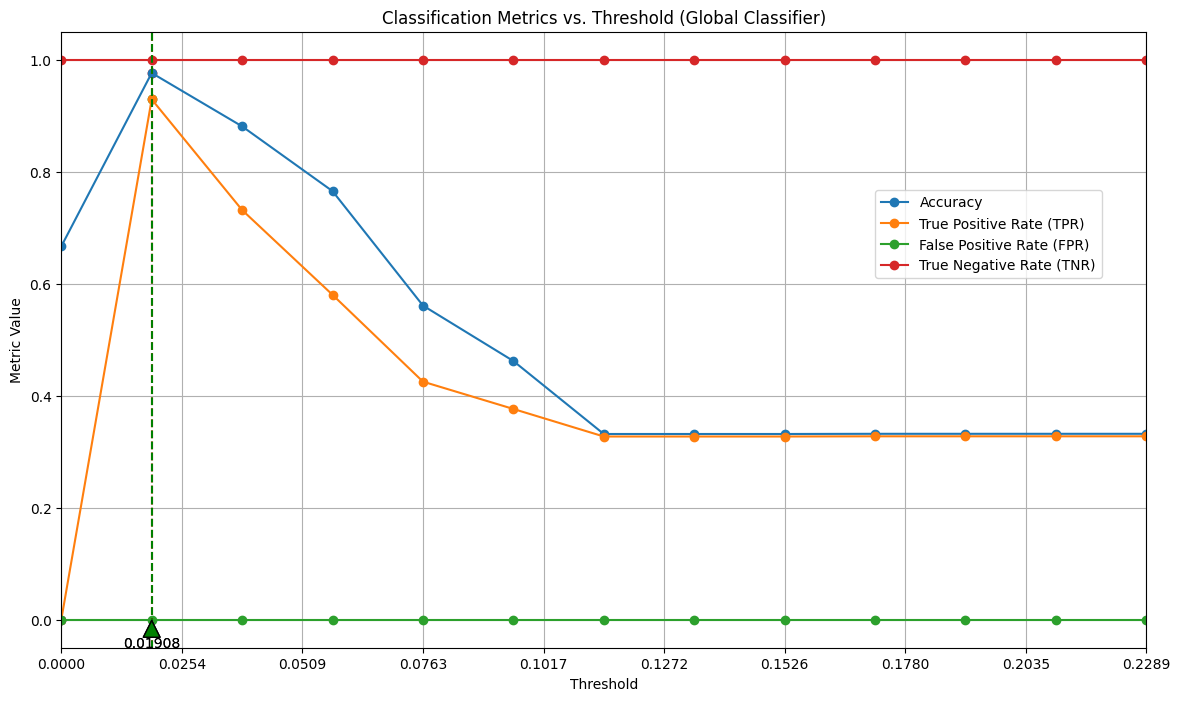

In [38]:
# Extracting data from 'fed_met' list
thresholds = [entry[0] for entry in first_fed_round]
accuracy = [entry[1] for entry in first_fed_round]
TPR = [entry[2] for entry in first_fed_round]
FPR = [entry[3] for entry in first_fed_round]
TNR = [entry[4] for entry in first_fed_round]

# Find the best thresholds
best_accuracy_idx = np.argmax(accuracy)
best_tpr_idx = np.argmax(TPR)
best_fpr_idx = np.argmin(FPR)

best_accuracy_threshold = thresholds[best_accuracy_idx]
best_tpr_threshold = thresholds[best_tpr_idx]

# Plotting
plt.figure(figsize=(14, 8))

# Accuracy
plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
plt.scatter(best_accuracy_threshold, accuracy[best_accuracy_idx], color='red')  # Highlight best accuracy

# True Positive Rate (TPR)
plt.plot(thresholds, TPR, label='True Positive Rate (TPR)', marker='o')
plt.scatter(best_tpr_threshold, TPR[best_tpr_idx], color='green')  # Highlight best TPR

# False Positive Rate (FPR)
plt.plot(thresholds, FPR, label='False Positive Rate (FPR)', marker='o')
plt.scatter(best_fpr_threshold, FPR[best_fpr_idx], color='blue')  # Highlight best (lowest) FPR
# True Negative Rate (TNR)
plt.plot(thresholds, TNR, label='True Negative Rate (TNR)', marker='o')

# Adjusting x-axis scale
plt.xlim(min(thresholds), max(thresholds))
plt.xticks(np.linspace(min(thresholds), max(thresholds), num=10))

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Classification Metrics vs. Threshold (Global Classifier)')
plt.legend(loc=(0.75, 0.6))
plt.grid(True)

# Add vertical dashed lines and annotate the x-axis
plt.axvline(x=best_accuracy_threshold, color='red', linestyle='--')
plt.annotate(f'{best_accuracy_threshold:.5f}', xy=(best_accuracy_threshold, 0), xytext=(best_accuracy_threshold, -0.05),
             arrowprops=dict(facecolor='red', shrink=0.05), horizontalalignment='center')

plt.axvline(x=best_tpr_threshold, color='green', linestyle='--')
plt.annotate(f'{best_tpr_threshold:.5f}', xy=(best_tpr_threshold, 0), xytext=(best_tpr_threshold, -0.05),
             arrowprops=dict(facecolor='green', shrink=0.05), horizontalalignment='center')

"""# Add a text box with the best values
textstr = '\n'.join((
    f'Best Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'Best TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}',
))

# Place a text box to the right of the plot
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.gcf().text(0.95, 0.5, textstr, fontsize=12, verticalalignment='center', bbox=props)

plt.show()"""
print(f'\nBest Accuracy: {accuracy[best_accuracy_idx]:.5f} at threshold {best_accuracy_threshold}',
    f'\nBest TPR: {TPR[best_tpr_idx]:.5f} at threshold {best_tpr_threshold}\n') 

In [39]:
compressed_test = {}
for data in test_data:
    for i in client_models:
        model = client_models[i]
        model.eval()
        layer_output = model(torch.Tensor(data))
        try:
            compressed_test[i].append(layer_output)
        except:
            compressed_test[i] = [layer_output]


In [40]:
best_tpr_threshold = 0.019209538523145032

In [41]:
def classify_new_data_fed(new_data_point, threshold):
    # Predict the cluster for the new data point
    new_data_cluster = new_kmeans.predict(np.array(new_data_point))
    # Get the centroid of the predicted cluster
    centroid = new_kmeans.cluster_centers_[new_data_cluster]
    # Calculate the Euclidean distance between the new data point and the centroid
    distance = np.sqrt(np.sum((new_data_point - centroid) ** 2))
    # Classify based on the distance
    if distance < threshold:
        return new_data_cluster[0]
    else:
        return False

threshold = best_tpr_threshold


# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    TP,FP,TN,FN = 0, 0, 0, 0
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data_fed(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data_fed(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


    print()
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # Calculate true positive rate (TPR) or sensitivity or recall
    TPR = TP / (TP + FN)

    # Calculate false positive rate (FPR)
    FPR = FP / (FP + TN)

    # Calculate specificity or true negative rate (TNR)
    TNR = TN / (FP + TN)

    # Calculate precision or positive predictive value (PPV)
    PPV = TP / (TP + FP)



    # Print the metrics with up to four decimal places
    print(f"Data from :" +str(model))
    print("TP:", f"{TP}")
    print("TN:", f"{TN}")
    print("FP:", f"{FP}")
    print("FN:", f"{FN}")
    print("Accuracy:", f"{accuracy*100:.4f}")
    print("True Positive Rate (TPR):", f"{TPR:.4f}")
    print("False Positive Rate (FPR):", f"{FPR:.4f}")
    print("True Negative Rate (TNR):", f"{TNR:.4f}")
    print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
    print()


Data from :DoS
TP: 4994
TN: 9922
FP: 0
FN: 84
Accuracy: 99.4400
True Positive Rate (TPR): 0.9835
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000


Data from :DDoS
TP: 4623
TN: 10000
FP: 0
FN: 377
Accuracy: 97.4867
True Positive Rate (TPR): 0.9246
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000


Data from :Mirai
TP: 4431
TN: 9999
FP: 0
FN: 570
Accuracy: 96.2000
True Positive Rate (TPR): 0.8860
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000



In [42]:
threshold = best_tpr_threshold
TP,FP,TN,FN = 0,0,0,0

# Iterate through the compressed_mixed dictionary and classify each data point
for model, data_list in compressed_test.items():
    j = 0
    for data in data_list:
        # Convert the data to NumPy array and detach from computation graph
        data_np = data.detach().numpy()
        data_np = data_np.reshape(1,-1)
        # Convert the data to double data type before passing it to KMeans model
        if classify_new_data_fed(data_np, threshold) == False:
            classification_result = False
        else: 
            classification_result = cluster_labels[classify_new_data_fed(data_np, threshold)]
        if classification_result == False:
            if model == test_data_labels[j]:
                FN += 1
            else:
                TN += 1
        else:
            if classification_result == test_data_labels[j]:
                if model == test_data_labels[j]:
                    TP += 1
                else:
                    FP += 1
            else:
                FN += 1
        j += 1
            


print()
# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate true positive rate (TPR) or sensitivity or recall
TPR = TP / (TP + FN)

# Calculate false positive rate (FPR)
FPR = FP / (FP + TN)

# Calculate specificity or true negative rate (TNR)
TNR = TN / (FP + TN)

# Calculate precision or positive predictive value (PPV)
PPV = TP / (TP + FP)



# Print the metrics with up to four decimal places
print(f"Global Classifier :")
print("TP:", f"{TP}")
print("TN:", f"{TN}")
print("FP:", f"{FP}")
print("FN:", f"{FN}")
print("Accuracy:", f"{accuracy*100:.4f}")
print("True Positive Rate (TPR):", f"{TPR:.4f}")
print("False Positive Rate (FPR):", f"{FPR:.4f}")
print("True Negative Rate (TNR):", f"{TNR:.4f}")
print("Positive Predictive Value (PPV):", f"{PPV:.4f}")
print()


Global Classifier :
TP: 14048
TN: 29921
FP: 0
FN: 1031
Accuracy: 97.7089
True Positive Rate (TPR): 0.9316
False Positive Rate (FPR): 0.0000
True Negative Rate (TNR): 1.0000
Positive Predictive Value (PPV): 1.0000



In [ ]:
import os
from joblib import dump

# Define the directory path
directory = '/kaggle/working/kmeans_models'

# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the kmeans model
dump(kmeans, '/kaggle/working/kmeans_models/kmeans_model.joblib')
# Save the kmeans model
#